In [65]:
import torch
import torch.nn as nn
from torchvision.models import vgg13

import numpy as np
import numpy.testing as npt

from PIL import Image, ImageEnhance, ImageChops
import os
import re
import random


from inspect import signature
import matplotlib.pyplot as plt
%matplotlib inline

Создадим класс датасет для фото

In [104]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
      
def sorted_aphanumeric(data, gender):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    data = map(lambda x:gender+x, data)
    return sorted(data, key=alphanum_key)

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        self.masks = None
        self.dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        
        
        self.images_male = sorted_aphanumeric(os.listdir(images_dir+"male/"), "male/")
        self.images_female = sorted_aphanumeric(os.listdir(images_dir+"female/"), "female/")
        self.images = self.images_male + self.images_female
        random.shuffle(self.images)
        
    def __len__(self):
        return len(os.listdir(self.dir+"male/"))+len(os.listdir(self.dir+"female/"))
    
    def __getitem__(self, idx):
        img = Image.open(self.dir+self.images[idx])
        if self.transforms:
            for trans in self.transforms:
              img = trans(img)
        if "female" in self.images[idx]:
            return img, 0
        else: return img, 1

Реализуем модуль аугментации фото 

In [67]:

class HorizontalFlip(object):
    def __init__(self, prob = 1):
        self.prob = prob
    def __call__(self, img, mask=None):
        self.method = np.random.choice(2, 1, p =[1-self.prob,self.prob])[0]
        if self.method:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            if mask:
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
                return img, mask
        return img
    
class cut(object):
    def __init__(self, prob = 1, output_size = None):
        self.prob = prob
        self.output_size = output_size
        
    def __call__(self, img, mask=None):
        self.method = np.random.choice(2, 1, p =[1-self.prob,self.prob])[0]
        if self.method:
            w, h = img.size
            if not self.output_size:
                new_w = int(np.random.normal(w/1.5, 30, 1)[0])
                new_h = int(np.random.normal(h/1.5, 30, 1)[0])

            else:
                new_w, new_h = self.output_size
            left = 0
            top = 0
            right = new_w
            bottom = new_h
            
            t = h - new_h
            l = w - new_w
            if t <= 0 and l<= 0:
                img = img.resize((new_w, new_h), Image.ANTIALIAS)
                if mask:
                    mask = mask.resize((new_w, new_h), Image.ANTIALIAS)
            elif t <= 0:
                img = img.resize((w, new_h), Image.ANTIALIAS)
                left = np.random.randint(0, l)
                right = left + new_w
            elif l <= 0:
                img = img.resize((new_w, h), Image.ANTIALIAS)
                top = np.random.randint(0, t)
                bottom = top + new_h
            else:
                top = np.random.randint(t)
                left = np.random.randint(l)
                bottom = top + new_h
                right = left + new_w
            img = img.crop((left, top, right, bottom))
            img = img.resize((224, 224), Image.ANTIALIAS)
            if mask:
                mask = mask.crop((left, top, right, bottom))
                mask = mask.resize((224, 224), Image.ANTIALIAS)
                return img, mask
            else: 
                return img
        if mask:
            return img, mask
        else: 
            img = img.resize((224, 224), Image.ANTIALIAS)
            return img
    
class brightness(object):
    def __init__(self, prob = 1):
        self.prob = prob
    def __call__(self, img):
        self.method = np.random.choice(2, 1, p =[1-self.prob,self.prob])[0]
        if self.method:
            br = np.random.uniform(0.3, 2.2, 1)[0]
            enh = ImageEnhance.Brightness(img)
            img = enh.enhance(br)
            return img
        return img
    

    
class ToTensor1(object):
    def __call__(self, img, mask=None):
        img = ToTensor()(img)
        if mask:
          mask = ToTensor()(mask)
          return img, mask
        return img

In [97]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
os.chdir('/content/gdrive/My Drive/test/')

Mounted at /content/gdrive/


In [ ]:
#!tar xvf internship_data.tar.gz

In [105]:
from torchvision.transforms import ToTensor, Normalize


#DATA_PATH = '/Users/daniilnerus/Documents/std/prak/'
DATA_PATH = '/content/gdrive/My Drive/test/'


train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'internship_data/',
    transforms= [HorizontalFlip(0.2), cut(0.1), brightness(0.3), ToTensor1(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
)

Выведем пару изображений,посмотрим, что делаем все правильно.

1


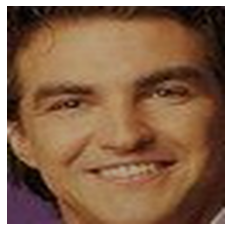

In [106]:
def show_idx_image(dataset, idx):
    mask_img, l = dataset[idx]
    image_to_show = mask_img.transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)
    plt.imshow(image_to_show)
    print(l)
    plt.axis('off')

show_idx_image(train_dataset, 10000)

Разобьем на трейн/тест и создадим из них загрузчики.

In [107]:
train_size = int(0.9 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [108]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

Реализуем функции для обучения, оценки качества и сохранения сети.

In [117]:
def evaluate_net(net, testloader, criterion, val_criterion=None, device='cpu'):
    net = net.eval()

    test_acc = 0.
    correct = 0.
    total = 0.
    device = torch.device('cuda:0')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images
            labels = labels
            
            images = images.to(device)
            labels = labels.to(device)
            outputs, _ = net(images)
            outputs = outputs.to(device)
            total += labels.size(0)
            _, prediction = torch.max(outputs.data, 1)
            test_acc += torch.sum(prediction == labels.data)
            #correct += float(val_criterion(outputs, labels).detach())

    mean_loss = test_acc / total
    #metric = correct / total
    
    return mean_loss#, metric

def save_models(epoch):
    torch.save(model.state_dict(), "nn_{}.model".format(epoch))
    print("Chekcpoint saved")

In [73]:
def optimize_net(num_epochs, model, train_loader, optimizer, criterion, criterion_dop = None,
                 testloader=None, use_cuda=True):
    device = torch.device('cuda:0')
    running_loss = 0
    total_step = len(train_loader)
    best_loss = 0
    for epoch in range(num_epochs):
        for i, (images, mask) in enumerate(train_loader):
            #print(images.shape, mask)
            images = images#[np.newaxis, :]
            mask = mask#[np.newaxis, :]
            images = images.to(device)
            mask = mask.to(device)

            # Forward pass
            outputs, _ = model(images)
            #print(outputs)
            loss = criterion(outputs, mask)#*0.5 + criterion_dop(outputs, mask)*0.5
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += float(loss)
            
            if (i+1) % 5 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, running_loss/5))
                running_loss = 0
        if testloader:
            test_loss= evaluate_net(model, testloader, criterion)
            print('test_loss: {:.3f}'.format(test_loss))
            if test_loss > best_loss:
              save_models(epoch)
              best_loss = test_loss


Зададим базовую VGG сеть

In [74]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2622),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(2622, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

И конфиг vgg11

In [75]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

Добавим батч нормализацию в VGG.

In [76]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c
            
    return nn.Sequential(*layers)

In [77]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

In [78]:
OUTPUT_DIM = 2

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Далее загрузим предобученную VGG11 модель. Так же заменим 2 последних полносвязнных слоя сети. 

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


In [ ]:
IN_FEATURES = pretrained_model.classifier[-4].in_features 
final_fc1 = nn.Linear(IN_FEATURES, 2622)
pretrained_model.classifier[-4] = final_fc1
final_fc = nn.Linear(2622, OUTPUT_DIM)
pretrained_model.classifier[-1] = final_fc

In [ ]:
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Определим минимальный lr для поиска оптимального, а так же оптимизатор, устройство на котором будет происходить обучение, loss функцию, а так же дополнительный лосс если будем использовать их взвешенную сумму.

In [79]:
START_LR = 1e-7

optimizer = torch.optim.Adam(model.parameters(), lr = START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
dop_criter = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)

Т.к. модель дообучалась, загрузим результат с предыдущего этапа обучения.

In [80]:
model.load_state_dict(torch.load('nn333_3.model'))

<All keys matched successfully>

Далее будем искать оптимальный lr

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device, dop_crit):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        self.dop_crit = dop_crit
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):
            print(iteration)
            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])
            lr_scheduler.step()
            
            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
        model.load_state_dict(torch.load('init_params.pt'))

                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)*0.5 + self.dop_crit(y_pred,y)*0.5
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device, dop_criter)
lrs, losses = lr_finder.range_test(train_data_loader, END_LR, NUM_ITER)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

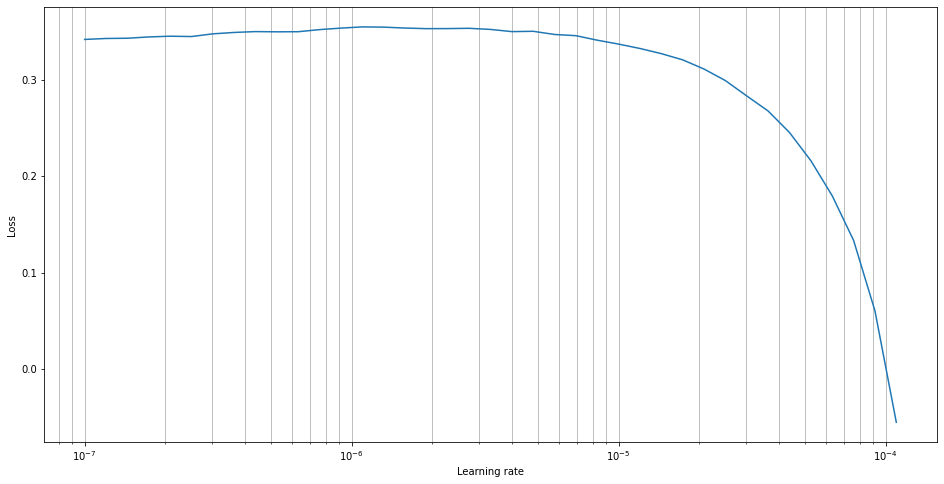

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 0, skip_end = 0)

Обучим модель.
(На самом деле с обучением в каллабе и на моем ноутбуке была беда, то ноутбук засыпал и процесс в каллабе прерывался, то каллаб исчерпал лимит использования gpu и чтения из google drive :)

In [ ]:
FOUND_LR = 9e-5

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = torch.optim.Adam(params, lr = FOUND_LR)

In [ ]:
num_epochs = 10
optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)

Epoch [1/10], Step [5/2803], Loss: 33.2768
Epoch [1/10], Step [10/2803], Loss: 29.7829
Epoch [1/10], Step [15/2803], Loss: 32.2013
Epoch [1/10], Step [20/2803], Loss: 30.3829
Epoch [1/10], Step [25/2803], Loss: 26.6786
Epoch [1/10], Step [30/2803], Loss: 28.8533
Epoch [1/10], Step [35/2803], Loss: 22.1048
Epoch [1/10], Step [40/2803], Loss: 14.8826
Epoch [1/10], Step [45/2803], Loss: 17.9476
Epoch [1/10], Step [50/2803], Loss: 16.1334
Epoch [1/10], Step [55/2803], Loss: 14.9147
Epoch [1/10], Step [60/2803], Loss: 14.2802
Epoch [1/10], Step [65/2803], Loss: 10.6196
Epoch [1/10], Step [70/2803], Loss: 13.4186
Epoch [1/10], Step [75/2803], Loss: 10.1412
Epoch [1/10], Step [80/2803], Loss: 17.7216
Epoch [1/10], Step [85/2803], Loss: 7.4493
Epoch [1/10], Step [90/2803], Loss: 12.5065
Epoch [1/10], Step [95/2803], Loss: 8.8421
Epoch [1/10], Step [100/2803], Loss: 6.1845
Epoch [1/10], Step [105/2803], Loss: 16.0262
Epoch [1/10], Step [110/2803], Loss: 4.9084
Epoch [1/10], Step [115/2803], Los

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-8d95414c72a3>", line 2, in <module>
    optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)
  File "<ipython-input-32-2165aeea28ab>", line 8, in optimize_net
    for i, (images, mask) in enumerate(train_loader):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 403, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packag

OSError: ignored

In [ ]:
num_epochs = 5
optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)

Epoch [1/5], Step [5/2803], Loss: 0.2665
Epoch [1/5], Step [10/2803], Loss: 1.9567
Epoch [1/5], Step [15/2803], Loss: 1.1466
Epoch [1/5], Step [20/2803], Loss: 0.6993
Epoch [1/5], Step [25/2803], Loss: 1.0004
Epoch [1/5], Step [30/2803], Loss: 1.0271
Epoch [1/5], Step [35/2803], Loss: 1.3995
Epoch [1/5], Step [40/2803], Loss: 0.9131
Epoch [1/5], Step [45/2803], Loss: 1.2920
Epoch [1/5], Step [50/2803], Loss: 2.6027
Epoch [1/5], Step [55/2803], Loss: 1.6612
Epoch [1/5], Step [60/2803], Loss: 1.3159
Epoch [1/5], Step [65/2803], Loss: 0.2575
Epoch [1/5], Step [70/2803], Loss: 1.1478
Epoch [1/5], Step [75/2803], Loss: 1.4026
Epoch [1/5], Step [80/2803], Loss: 1.7544
Epoch [1/5], Step [85/2803], Loss: 1.1056
Epoch [1/5], Step [90/2803], Loss: 0.5507
Epoch [1/5], Step [95/2803], Loss: 1.3155
Epoch [1/5], Step [100/2803], Loss: 1.4522
Epoch [1/5], Step [105/2803], Loss: 0.7701
Epoch [1/5], Step [110/2803], Loss: 1.2090
Epoch [1/5], Step [115/2803], Loss: 0.6380
Epoch [1/5], Step [120/2803], L

IsADirectoryError: ignored

Epoch [1/3], Step [5/2803], Loss: 0.2583
Epoch [1/3], Step [10/2803], Loss: 0.9021
Epoch [1/3], Step [15/2803], Loss: 1.7201
Epoch [1/3], Step [20/2803], Loss: 0.8098
Epoch [1/3], Step [25/2803], Loss: 0.8189
Epoch [1/3], Step [30/2803], Loss: 0.7000
Epoch [1/3], Step [35/2803], Loss: 1.5035
Epoch [1/3], Step [40/2803], Loss: 0.5918
Epoch [1/3], Step [45/2803], Loss: 0.8556
Epoch [1/3], Step [50/2803], Loss: 1.0093
Epoch [1/3], Step [55/2803], Loss: 0.5792
Epoch [1/3], Step [60/2803], Loss: 0.8673
Epoch [1/3], Step [65/2803], Loss: 1.0716
Epoch [1/3], Step [70/2803], Loss: 0.8726
Epoch [1/3], Step [75/2803], Loss: 0.8389
Epoch [1/3], Step [80/2803], Loss: 0.8836
Epoch [1/3], Step [85/2803], Loss: 0.5808
Epoch [1/3], Step [90/2803], Loss: 0.8842
Epoch [1/3], Step [95/2803], Loss: 1.6813
Epoch [1/3], Step [100/2803], Loss: 0.4043
Epoch [1/3], Step [105/2803], Loss: 0.7611
Epoch [1/3], Step [110/2803], Loss: 0.6791
Epoch [1/3], Step [115/2803], Loss: 0.3323
Epoch [1/3], Step [120/2803], L

KeyboardInterrupt: ignored

In [ ]:
num_epochs = 3
optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)

Epoch [1/3], Step [5/2803], Loss: 0.7651
Epoch [1/3], Step [10/2803], Loss: 0.6211
Epoch [1/3], Step [15/2803], Loss: 1.4253
Epoch [1/3], Step [20/2803], Loss: 0.2721
Epoch [1/3], Step [25/2803], Loss: 1.0785
Epoch [1/3], Step [30/2803], Loss: 1.4652
Epoch [1/3], Step [35/2803], Loss: 0.3592
Epoch [1/3], Step [40/2803], Loss: 1.3728
Epoch [1/3], Step [45/2803], Loss: 0.8255
Epoch [1/3], Step [50/2803], Loss: 0.2693
Epoch [1/3], Step [55/2803], Loss: 1.9532
Epoch [1/3], Step [60/2803], Loss: 0.6356
Epoch [1/3], Step [65/2803], Loss: 1.9491
Epoch [1/3], Step [70/2803], Loss: 0.7459
Epoch [1/3], Step [75/2803], Loss: 0.9181
Epoch [1/3], Step [80/2803], Loss: 1.8779
Epoch [1/3], Step [85/2803], Loss: 0.3267
Epoch [1/3], Step [90/2803], Loss: 2.2400
Epoch [1/3], Step [95/2803], Loss: 0.8680
Epoch [1/3], Step [100/2803], Loss: 1.1219
Epoch [1/3], Step [105/2803], Loss: 0.8635
Epoch [1/3], Step [110/2803], Loss: 2.2458
Epoch [1/3], Step [115/2803], Loss: 0.4748
Epoch [1/3], Step [120/2803], L

In [81]:
num_epochs = 2
optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)

Epoch [1/2], Step [5/1402], Loss: 0.6748
Epoch [1/2], Step [10/1402], Loss: 0.3930
Epoch [1/2], Step [15/1402], Loss: 0.3631
Epoch [1/2], Step [20/1402], Loss: 0.8811
Epoch [1/2], Step [25/1402], Loss: 0.9552
Epoch [1/2], Step [30/1402], Loss: 1.2193
Epoch [1/2], Step [35/1402], Loss: 0.8083
Epoch [1/2], Step [40/1402], Loss: 0.9155
Epoch [1/2], Step [45/1402], Loss: 0.7194
Epoch [1/2], Step [50/1402], Loss: 0.5130
Epoch [1/2], Step [55/1402], Loss: 1.2121
Epoch [1/2], Step [60/1402], Loss: 1.1782
Epoch [1/2], Step [65/1402], Loss: 0.7135
Epoch [1/2], Step [70/1402], Loss: 1.3476
Epoch [1/2], Step [75/1402], Loss: 0.9954
Epoch [1/2], Step [80/1402], Loss: 0.7562
Epoch [1/2], Step [85/1402], Loss: 0.6597
Epoch [1/2], Step [90/1402], Loss: 0.2560
Epoch [1/2], Step [95/1402], Loss: 0.5876
Epoch [1/2], Step [100/1402], Loss: 1.1642
Epoch [1/2], Step [105/1402], Loss: 1.3288
Epoch [1/2], Step [110/1402], Loss: 0.8320
Epoch [1/2], Step [115/1402], Loss: 0.8322
Epoch [1/2], Step [120/1402], L

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-81-0809d3d62df4>", line 2, in <module>
    optimize_net(num_epochs, model, train_data_loader, optimizer, criterion, dop_criter, test_data_loader)
  File "<ipython-input-73-2165aeea28ab>", line 8, in optimize_net
    for i, (images, mask) in enumerate(train_loader):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 363, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 403, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packag

OSError: ignored

In [ ]:
torch.save(model.state_dict(), "nn333_{}.model".format(3))

Оценим качество

In [118]:
evaluate_net(model, test_data_loader, criterion)

tensor(0.9514, device='cuda:0')